In [1]:
import pandas as pd
import numpy as np

import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

# Import libraries to build Word2Vec model, and load Newsgroups data
import os
import sys
import re

from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import spacy

from wordcloud import WordCloud
#from wordcloud import WordCloud, STOPWORDS

# WORD VECTOR
from gensim.models import Word2Vec
# BIGRAM
from gensim.models.phrases import Phraser, Phrases
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
stemmer = SnowballStemmer("english")


### Part 1: Load the data

In [2]:
# OUTPUT FILES IN DIRECTORY
print(os.listdir("C:/Users/DJ/Documents/AnacondaPython/Thinkful/FilesToLoad/wine-reviews"))

['wine-reviews.zip', 'winemag-data-130k-v2.csv', 'winemag-data-130k-v2.json', 'winemag-data_first150k.csv']


In [3]:
# LOAD FILE FROM CSV
wine_130k = pd.read_csv(("../FilesToLoad/wine-reviews/winemag-data-130k-v2.csv"))
wine_150k = pd.read_csv(("../FilesToLoad/wine-reviews/winemag-data_first150k.csv"))
df = pd.concat([wine_150k, wine_130k],axis=0, sort=False)
#wine = wine_150k
print("Number of rows and columns:",df.shape)

Number of rows and columns: (280901, 14)


In [4]:
df.shape

(280901, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280901 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               280901 non-null int64
country                  280833 non-null object
description              280901 non-null object
designation              197701 non-null object
points                   280901 non-null int64
price                    258210 non-null float64
province                 280833 non-null object
region_1                 234594 non-null object
region_2                 111464 non-null object
variety                  280900 non-null object
winery                   280901 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 32.1+ MB


### Part 2: Clean Data

#### Duplicates exist in description, but are missed if analyzing duplicate for row.

In [6]:
# DUPLICATE COUNTS (ROWS, COLUMNS)
print("Row level duplicates:   {}".format(df[df.duplicated()].shape))
print("Description duplicates: {}".format(df[df.duplicated('description')].shape))

Row level duplicates:   (0, 14)
Description duplicates: (111471, 14)


In [7]:
# VIEW DUPLICATES
df[df.duplicated(subset='description', keep=False)==True].sort_values(by='description', ascending=True).head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title
94355,94355,Austria,"""Chremisa,"" the ancient name of Krems, is comm...",Edition Chremisa Sandgrube 13,85,24.0,Niederösterreich,NaN,NaN,Grüner Veltliner,Winzer Krems,Roger Voss,@vossroger,Winzer Krems 2011 Edition Chremisa Sandgrube 1...
96052,96052,Austria,"""Chremisa,"" the ancient name of Krems, is comm...",Edition Chremisa Sandgrube 13,85,24.0,Niederösterreich,NaN,NaN,Grüner Veltliner,Winzer Krems,NaN,NaN,NaN


In [8]:
print(df['description'].head(1))

0    This tremendous 100% varietal wine hails from ...
Name: description, dtype: object


In [9]:
# TOP VARIETALS IN CALIFORNIA BY REVIEW COUNT
df[df['province']=='California']['variety'].value_counts().head(17)

# RED VARIETALS
#Pinot Noir                    8828
#Cabernet Sauvignon            7873
#Zinfandel                     3691
#Syrah                         2668
#Merlot                        2155
#Petite Sirah                   914
#Cabernet Franc                 469
#Grenache                       427

Pinot Noir                  14529
Cabernet Sauvignon          13145
Chardonnay                  11719
Zinfandel                    6330
Syrah                        4575
Sauvignon Blanc              4027
Merlot                       3684
Red Blend                    3587
Bordeaux-style Red Blend     2006
Petite Sirah                 1524
Sparkling Blend              1085
Rosé                         1003
Viognier                      985
Rhône-style Red Blend         970
Cabernet Franc                795
White Blend                   739
Pinot Grigio                  694
Name: variety, dtype: int64

In [10]:
# LOOK UP STR 
#https://stackoverflow.com/questions/11350770/select-by-partial-string-from-a-pandas-dataframe
    
#CONTAINS THE STRING
#df_ca[df_ca['variety'].str.contains('iogn')]['variety'].value_counts()

# STARTS WITH THE STRING
#df_ca[df_ca['variety'].str.match('Sauv')]['variety'].value_counts()
#df_ca[df_ca['variety'].str.match('Cab')]['variety'].value_counts()

#pat = Rules.SearchTerms.str.replace('\*', r'.*').str.cat(sep='|')
#df[df.Column.str.contains(pat, flags=re.I)

In [11]:
# DROP DUPLICATES
df.drop_duplicates('description', keep='first', inplace=True)
print("Description duplicates: {}".format(df[df.duplicated('description')].shape))
print("Dataframe shape: {}".format(df.shape))

Description duplicates: (0, 14)
Dataframe shape: (169430, 14)


#### Duplicates based on description removed. The 'Unnamed 0' column appears to be an index duplicate. Let's remove.

In [12]:
# DROP 'Unnamed: 0 FROM DATAFRAME
df.drop(['Unnamed: 0'], axis=1, inplace=True)

#### Null values, we want to work with points, price and description, variety, winery and country primarily and will drop any row with null values in those categories.  

In [13]:
df.dropna(axis=0, subset=['country','price', 'variety'], inplace=True)

In [14]:
#df.isnull().mean()

### Step 3: Preprocessing and EDA

#### Create log of price.

In [15]:
# include='all' FOR ALL, include='O' FOR STRING, include () FOR NUMERIC
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,156552,48,US,70491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,156552,156552,Here's a lovely interpretation of Barbera Supe...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,110034,44351,Reserve,2802,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,156552,NaN,NaN,NaN,88.1924,3.15024,80,86,88,90,100
price,156552,NaN,NaN,NaN,34.6458,39.3853,4,16,25,40,3300
province,156552,483,California,48458,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,130976,1307,Napa Valley,6401,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,67184,18,Central Coast,14504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,156552,739,Pinot Noir,15983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
winery,156552,18143,Williams Selyem,299,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Univariate Analysis

#### Price Outlier

Text(0.5, 1.0, 'price')

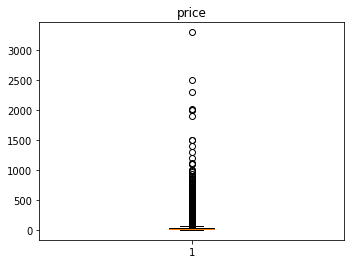

In [16]:
plt.figure(figsize=(12,4))

# BOXPLOT
plt.subplot(1,2,1)
plt.boxplot(df['price'],whis=1.5)
plt.title('price')

#### Although there is a wide range of prices, the variance is legitimate. Certain wineries command a premium due to quality, scarcity, and prestige. To explain the wine market, we will introduce market three primary categories each with three sub categories. The segments are based on price per 750ml.

#### Rating ("points") Outlier Analysis

Text(0.5, 1.0, 'Rating')

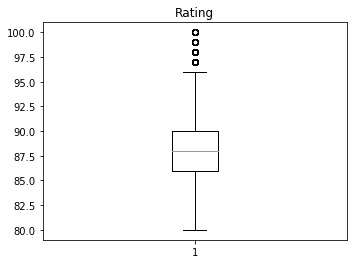

In [17]:
plt.figure(figsize=(12,4))

# BOXPLOT
plt.subplot(1,2,1)
plt.boxplot(df['points'],whis=1.5)
plt.title('Rating')

#### Majority of ratings rank the wines between 86 and 90 points where greater than 90 points appears to be a designation for an above average wine, and less than 86 a below average wine with a few outliers on the upside which speak to unique high quality wines.

#### Bivariate Analysis

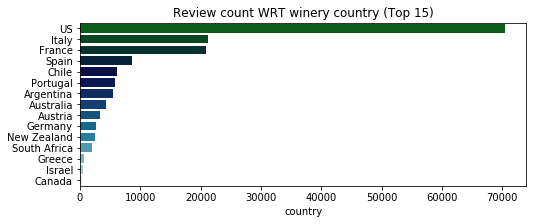

In [18]:
plt.figure(figsize=(8,3))
# CONVERT SERIES TO DATAFRAME. cnt IS DF WHERE INDEX IS COUNTRY AND COUNTS ARE FEATURE 
# cnt['country'] IS REVIEW COUNTS, NOT COUNTRY NAME
cnt = df['country'].value_counts().to_frame()[0:15]
#plt.xscale('log')
sns.barplot(x= cnt['country'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Review count WRT winery country (Top 15)');

#### Majority of wineries with reviews in this dataset are in US, France and Italy.

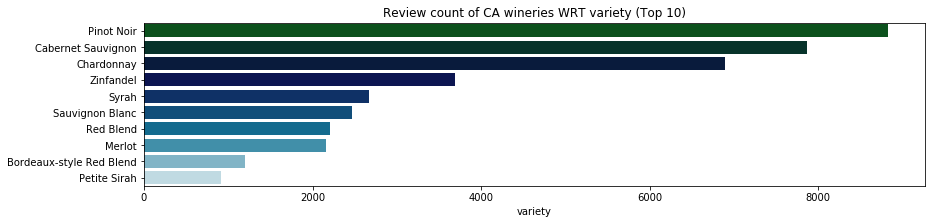

In [19]:
plt.figure(figsize=(14,3))
# CONVERT SERIES TO DATAFRAME. cnt IS DF WHERE INDEX IS COUNTRY AND COUNTS ARE FEATURE 
# cnt['country'] IS REVIEW COUNTS, NOT COUNTRY NAME
cnt = df[(df['country'] == 'US') & (df['province'] =='California')]['variety'].value_counts().to_frame()[0:10]
#plt.xscale('log')
sns.barplot(x= cnt['variety'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Review count of CA wineries WRT variety (Top 10)');

#### The pinot noir grape is the most reviewed variety. For this Capstone, we will focus on the pinot noir wine market in California.

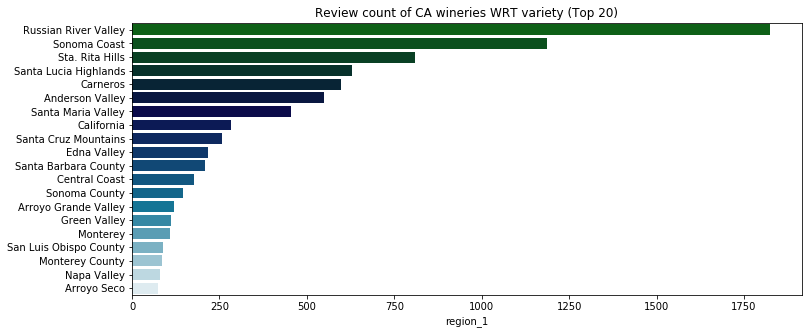

In [20]:
plt.figure(figsize=(12,5))
# CONVERT SERIES TO DATAFRAME. cnt IS DF WHERE INDEX IS COUNTRY AND COUNTS ARE FEATURE 
# cnt['country'] IS REVIEW COUNTS, NOT COUNTRY NAME
cnt = df[(df['country'] == 'US') & (df['province'] =='California') & (df['variety'] == 'Pinot Noir')]['region_1'].value_counts().to_frame()[0:20]
#plt.xscale('log')
sns.barplot(x= cnt['region_1'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Review count of CA wineries WRT variety (Top 20)');

#### Focus will be on US wine market, particularly California and the Pinot Noir variety as it get's the most reviews.

In [21]:
pn_region_list = ['Russian River Valley', 'Sonoma Coast', 'Sta. Rita Hills',
       'Santa Lucia Highlands', 'Carneros', 'Anderson Valley',
       'Santa Maria Valley', 'California', 'Santa Cruz Mountains',
       'Edna Valley', 'Santa Barbara County', 'Central Coast', 'Sonoma County',
       'Arroyo Grande Valley', 'Green Valley', 'Monterey',
       'San Luis Obispo County', 'Monterey County', 'Napa Valley',
       'Arroyo Seco']

df_pn20_prc = df[(df['country'] == 'US') & 
                 (df['province'] =='California') & 
                 (df['variety'] == 'Pinot Noir') &
                 (df['region_1'].isin(pn_region_list))].copy()

df_pn20_pnt = df[(df['country'] == 'US') & 
                 (df['province'] =='California') & 
                 (df['variety'] == 'Pinot Noir') &
                 (df['region_1'].isin(pn_region_list))].copy()

In [22]:
#df_pn20 = df_pn20[df_pn20['region_1'].isin(pn_region_list)]
#df_pn20.reset_index()
print("Number unique regions:                           {}".format(df_pn20_prc['region_1'].nunique()))
print("Shape of new Top 20 Pinot Noir Region Dataframe: {}".format(df_pn20_prc.shape))
df_pn20_prc.head(1)

Number unique regions:                           20
Shape of new Top 20 Pinot Noir Region Dataframe: (8013, 13)


,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm,NaN,NaN,NaN


In [23]:
# !!! STANDARDIZE VS LOG
df_pn20_prc['price_log'] = np.log(df_pn20_prc['price'])

In [24]:
df_pn20_prc.drop(columns=['country', 'variety', 'region_2','taster_name','taster_twitter_handle'], 
                 axis=1, inplace=True)

In [25]:
df_pn20_pnt.drop(columns=['country','variety', 'region_2','taster_name','taster_twitter_handle'], 
                 axis=1, inplace=True)

In [26]:
df_pn20_prc.columns

Index(['description', 'designation', 'points', 'price', 'province', 'region_1',
       'winery', 'title', 'price_log'],
      dtype='object')

In [27]:
df_pn20_pnt.columns

Index(['description', 'designation', 'points', 'price', 'province', 'region_1',
       'winery', 'title'],
      dtype='object')

#### Price by Region

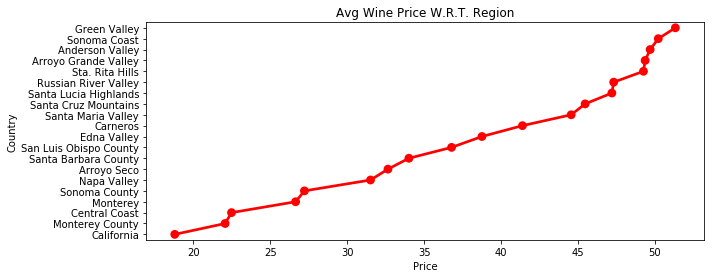

In [28]:
cnt = df_pn20_prc.groupby(['region_1']).mean()['price'].sort_values(ascending=False).to_frame()[0:20]
plt.figure(figsize=(10,4))
sns.pointplot(x=cnt['price'], y=cnt.index, color='r', orient='h', markers='o')
plt.title('Avg Wine Price W.R.T. Region')
plt.xlabel('Price')
plt.ylabel('Country');

#### Outlier analysis with boxplot

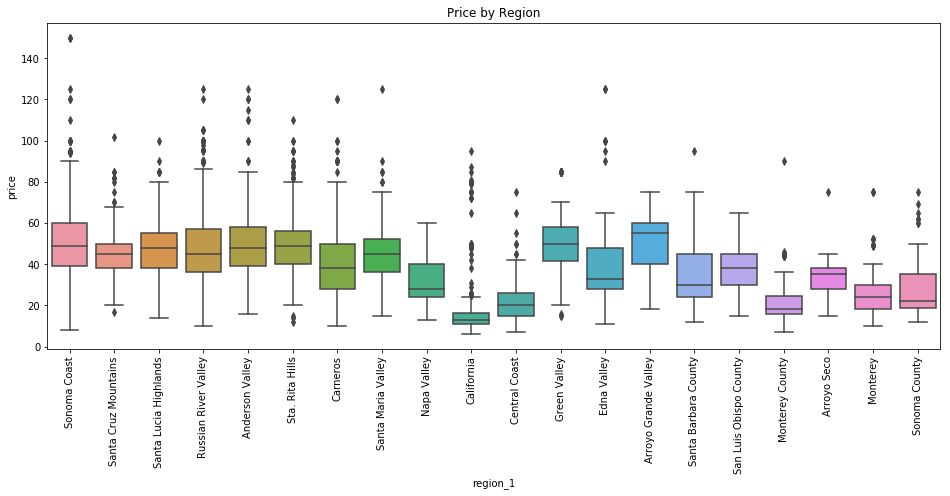

In [29]:
#    The rating of wine is varies from 0 to 100, but least rating is 80.
#    The wine produced in France, Australia, Portugal, Italy, US receives top rating.
#    The wine produced in Urugay, South Africa, Portugal reveices least rating.

plt.figure(figsize=(16,6))
sns.boxplot(x = df_pn20_prc['region_1'], y = df_pn20_prc['price'])
#sns.pointplot(x = wine['country'], y = wine['points'])
plt.title('Price by Region')
plt.xticks(rotation=90);

#### Ratings by Region

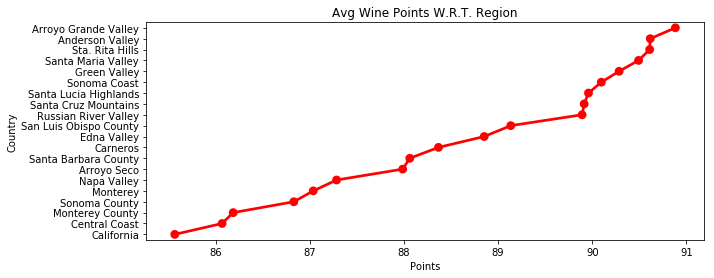

In [30]:
cnt = df_pn20_pnt.groupby(['region_1']).mean()['points'].sort_values(ascending=False).to_frame()[0:20]
plt.figure(figsize=(10,4))
sns.pointplot(x=cnt['points'], y=cnt.index, color='r', orient='h', markers='o')
plt.title('Avg Wine Points W.R.T. Region')
plt.xlabel('Points')
plt.ylabel('Country');

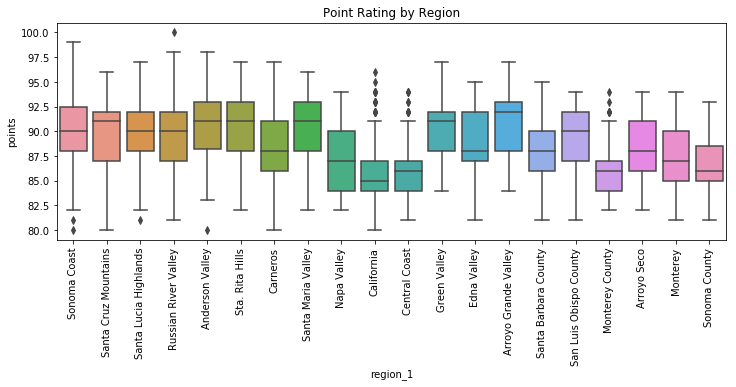

In [31]:
#    The rating of wine is varies from 0 to 100, but least rating is 80.

plt.figure(figsize=(12,4))
sns.boxplot(x = df_pn20_pnt['region_1'], y = df_pn20_pnt['points'])
#sns.pointplot(x = wine['country'], y = wine['points'])
plt.title('Point Rating by Region')
plt.xticks(rotation=90);

  
#### Luxury Super Segment  
Icon over 100   
Super Luxury 50 to 100  
Luxury 25 to 50   

#### Premium Super Segment    
Ultra Premium 14 to 25   
Mid-Premium 10 to 14   
Popular Premium 7 to 10   

#### Everyday Super Segment   
Fighting Varietals 3 up to 7    
Extreme Value Below 3    
Jug Wine Below 3  

Analysis: 
Talk to price, why such wide range, concentration, and legitimacy of values. 
Talk to rating scale and what happening.
Talk to how going to approach analysis, segments, varietals, specific region for specific varietal.
Talk to complication of wine market, Rhone, multiple regions, each has a specific recipe and rules. Diff than that of US
US Syrah, not always all Syrah, over certain percentage, may be blended with Viognier, Grenache, Mouvedre, etc ..., but called Syrah
So Syrah in US may not be similar to Syrah in Australia or France, all have rules. 
Also flavor different,terrior as it is called, a 100% syrah in diff parts of France or US or Australia will taste different within their own country and in contrast to other parts of world. This is function of weather, soil, and farming practices.

For these reasons breaking down analysis. Will use high level aggregations to identify common threads for flavor, smell characteristics to find variatal similarities. Will value based on specific province/region combination. Will recommend using user preferences, rating/review perception of quality, and similarities to other varietals.

Other issues, if don't look on a varietal basis, then can be deceiving. Example Rhone grows Syrah, Bordeaux will not have Syrah reviews. Rhone considered one of, if not the best Syrah growing region, particularly Hermitage and Cote Rotie. To compare Hermitage with Croze hermitage is like comparing the best wine region in California to central Valley mass market farming. One is targeting the high end, the "Luxury" market, the other the low end, the "Everyday" market, to say another way. 

So the wine market is complex, best way to approach is by variety, and by segment and to avoid generalizing too much as the price/rating scales will lose meaning and not be of use to the consumer and business. 

As we are building an app to help the consumer, we want to make accurate predictions. 

Let's go over this reasoning with bivariate analysis.

#### Assign percentile rank

In [32]:
# RANK - Assign price rank by grouping all Pinot Noir Ratings 1-3, organizing by 33 percentile
df_pn20_prc['price_rank']=pd.qcut(df_pn20_prc['price'],4,labels=False)
df_pn20_prc.tail(1)

,description,designation,points,price,province,region_1,winery,title,price_log,price_rank
129912,From the Ranch House block of the famous viney...,Durell Vineyard,91,55.0,California,Sonoma Coast,Dunstan,Dunstan 2014 Durell Vineyard Pinot Noir (Sonom...,4.007333,2


In [33]:
# RANK - Assign price rank by grouping all Pinot Noir Ratings 1-3, organizing by 33 percentile
df_pn20_pnt['point_rank']=pd.qcut(df_pn20_pnt['points'],4,labels=False)
df_pn20_pnt.tail(1)

,description,designation,points,price,province,region_1,winery,title,point_rank
129912,From the Ranch House block of the famous viney...,Durell Vineyard,91,55.0,California,Sonoma Coast,Dunstan,Dunstan 2014 Durell Vineyard Pinot Noir (Sonom...,2


In [34]:
df_pn20_pnt['point_rank'].value_counts()

0    2427
1    2133
2    1770
3    1683
Name: point_rank, dtype: int64

#### Price and point rank analysis

#### Price Rank

In [35]:
df_pn20_prc[df_pn20_prc['price_rank']==3].describe()

,points,price,price_log,price_rank
count,1793.000000,1793.000000,1793.000000,1793.0
mean,91.778026,68.172895,4.209594,3.0
std,2.685491,11.610504,0.152600,0.0
min,81.000000,56.000000,4.025352,3.0
25%,90.000000,60.000000,4.094345,3.0
50%,92.000000,65.000000,4.174387,3.0
75%,94.000000,75.000000,4.317488,3.0
max,100.000000,150.000000,5.010635,3.0


#### Analysis: When looking at the price rank, there appears to be a wide point range for all categories.  

>0: price 6 -> 32,  points 80 -> 95   
1: price 33 -> 44,  points 80 -> 96   
2: price 45 -> 55,  points 80 -> 98   
3: price 56 -> 150, points 81 -> 100  

In [36]:
df_pn20_pnt['reg1_pnt_mean'] = df_pn20_pnt.groupby('region_1')['points'].transform('mean')
df_pn20_pnt['reg1_pnt_rank'] = df_pn20_pnt['reg1_pnt_mean'].rank(method='dense', ascending=False)
#df_pn20.head(15)
#df_pn20['reg1_pnt_rank'].value_counts()

In [37]:
df_pn20_prc['reg1_prc_mean'] = df_pn20_prc.groupby('region_1')['price'].transform('mean')
df_pn20_prc['reg1_prc_rank'] = df_pn20_prc['reg1_prc_mean'].rank(method='dense', ascending=False)
#df_pn20.head(15)
#df_pn20['reg1_prc_rank'].value_counts()

Text(0.5, 1.0, 'points divided by reg1_pnts')

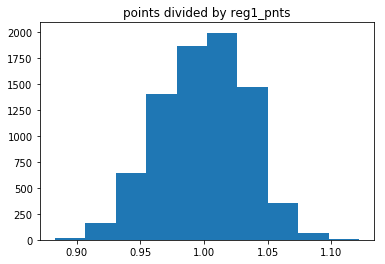

In [38]:
def reg1_pnt_ratio(row):
    if ((row['points'] != 0) & (row['reg1_pnt_mean'] !=0)):
        pnt_d_prc = row['points'] / row['reg1_pnt_mean'] 
    else:
        pnt_d_prc =  0 
    return pnt_d_prc

df_pn20_pnt['pnt_2_reg1pnt_ratio'] = df_pn20_pnt.apply(reg1_pnt_ratio, axis=1)

plt.figure(figsize=(6,4))
plt.hist(df_pn20_pnt['pnt_2_reg1pnt_ratio'])
plt.title("{}".format('points divided by reg1_pnts')) 

Text(0.5, 1.0, 'price divided by region mean price')

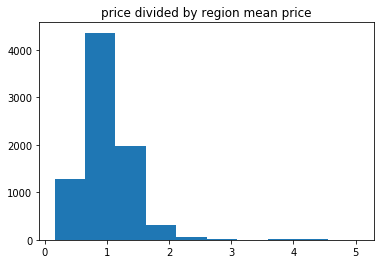

In [39]:
def reg1_prc_ratio(row):
    if ((row['price'] != 0) & (row['reg1_prc_mean'] !=0)):
        prc_d_prc_mean = row['price'] / row['reg1_prc_mean'] 
    else:
        pnt_d_prc =  0 
    return prc_d_prc_mean

df_pn20_prc['prc_2_reg1prc_ratio'] = df_pn20_prc.apply(reg1_prc_ratio, axis=1)

plt.figure(figsize=(6,4))
plt.hist(df_pn20_prc['prc_2_reg1prc_ratio'])
plt.title("{}".format('price divided by region mean price')) 

In [40]:
corr=df_pn20_prc.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,points,price,price_log,price_rank,reg1_prc_mean,reg1_prc_rank,prc_2_reg1prc_ratio
points,1,0.562636,0.584698,0.540202,0.382123,-0.36007,0.423762
price,0.562636,1,0.952712,0.917066,0.472611,-0.45691,0.839294
price_log,0.584698,0.952712,1,0.890946,0.582863,-0.547377,0.763672
price_rank,0.540202,0.917066,0.890946,1,0.433325,-0.421282,0.758257
reg1_prc_mean,0.382123,0.472611,0.582863,0.433325,1,-0.966779,-5.00846e-17
reg1_prc_rank,-0.36007,-0.45691,-0.547377,-0.421282,-0.966779,1,7.79886e-17
prc_2_reg1prc_ratio,0.423762,0.839294,0.763672,0.758257,-5.00846e-17,7.79886e-17,1


In [41]:
corr=df_pn20_pnt.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,points,price,point_rank,reg1_pnt_mean,reg1_pnt_rank,pnt_2_reg1pnt_ratio
points,1,0.562636,0.934854,0.397934,-0.37936,0.917311
price,0.562636,1,0.528014,0.453832,-0.418553,0.416665
point_rank,0.934854,0.528014,1,0.346731,-0.336432,0.867048
reg1_pnt_mean,0.397934,0.453832,0.346731,1,-0.953322,5.81024e-17
reg1_pnt_rank,-0.37936,-0.418553,-0.336432,-0.953322,1,-2.63915e-16
pnt_2_reg1pnt_ratio,0.917311,0.416665,0.867048,5.81024e-17,-2.63915e-16,1


In [42]:
# SIMPLE FILTERING MODELS
# TAKE REGION POINT / PRICE MAKE A RATIO, 
# ACTUAL POINT / REGION MEAN POINT 
# ACTUAL PRICE / REGION MEAN PRICE
# SIMPLE MODEL COULD BE  IF POINT RATIO > 1 AND PRICE RATIO < 1, THEN VALUE FOR REGION
# ANOTHER SIMPLE MODEL WOULD BE IF POINT_RANK IS > REGION POINT RANK AND PRICE RANK IS <= REGION PRICE RANK

Text(0.5, 1.0, 'Icon')

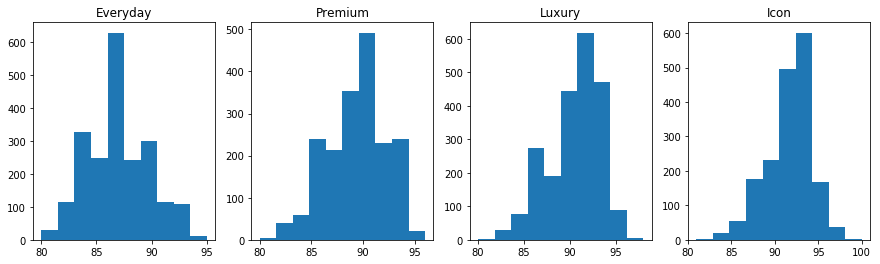

In [43]:
plt.figure(figsize=(15,4))
df_pn20_prc[df_pn20_prc['price_rank']==1]
# BAR PLOT
plt.subplot(1, 4, 1)
plt.hist(df_pn20_prc[df_pn20_prc['price_rank']==0]['points'])
plt.title("{}".format('Everyday')) 

# DENSITY PLOT - HISTOGRAM
plt.subplot(1, 4, 2)
plt.hist(df_pn20_prc[df_pn20_prc['price_rank']==1]['points'])
plt.title("{}".format('Premium'))   
    
# TUKEY: DETECT OUTLIERS IN VARIABLES USING BOX PLOTS
plt.subplot(1, 4, 3)
plt.hist(df_pn20_prc[df_pn20_prc['price_rank']==2]['points'] )
plt.title("{}".format('Luxury')) 

# TUKEY: DETECT OUTLIERS IN VARIABLES USING BOX PLOTS
plt.subplot(1, 4, 4)
plt.hist(df_pn20_prc[df_pn20_prc['price_rank']==3]['points'] )
plt.title("{}".format('Icon')) 

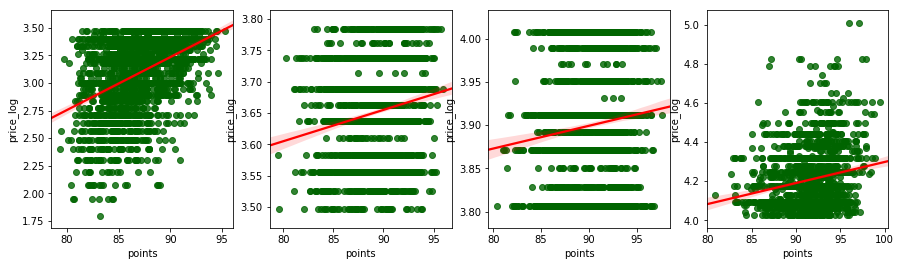

In [44]:
plt.figure(figsize=(15,4))

plt.subplot(1, 4, 1)
df_scatter = df_pn20_prc[df_pn20_prc['price_rank']==0]
g = sns.regplot(x='points', y='price_log', data=df_scatter, line_kws={'color':'red'}, 
                x_jitter=True, fit_reg=True, color='darkgreen')
#g.set_title("Points x Price Distribuition", fontsize=15)
#g.set_xlabel("Points", fontsize= 15)
#g.set_ylabel("Price", fontsize= 15)
#plt.show()

plt.subplot(1, 4, 2)
df_scatter = df_pn20_prc[df_pn20_prc['price_rank']==1]
g = sns.regplot(x='points', y='price_log', data=df_scatter, line_kws={'color':'red'}, 
                x_jitter=True, fit_reg=True, color='darkgreen')
#g.set_title("Points x Price Distribuition", fontsize=15)
#g.set_xlabel("Points", fontsize= 15)
#g.set_ylabel("Price", fontsize= 15)
#plt.show()

plt.subplot(1, 4, 3)
df_scatter = df_pn20_prc[df_pn20_prc['price_rank']==2]
g = sns.regplot(x='points', y='price_log', data=df_scatter, line_kws={'color':'red'}, 
                x_jitter=True, fit_reg=True, color='darkgreen')
#g.set_title("Points x Price Distribuition", fontsize=15)
#g.set_xlabel("Points", fontsize= 15)
#g.set_ylabel("Price", fontsize= 15)

plt.subplot(1, 4, 4)
df_scatter = df_pn20_prc[df_pn20_prc['price_rank']==3]
g = sns.regplot(x='points', y='price_log', data=df_scatter, line_kws={'color':'red'}, 
                x_jitter=True, fit_reg=True, color='darkgreen')

plt.show()

#### Point Rank

In [45]:
df_pn20_pnt[df_pn20_pnt['point_rank']==3].describe()

,points,price,point_rank,reg1_pnt_mean,reg1_pnt_rank,pnt_2_reg1pnt_ratio
count,1683.000000,1683.000000,1683.0,1683.000000,1683.000000,1683.000000
mean,93.797386,57.395128,3.0,90.000378,6.485443,1.042268
std,1.035605,15.939172,0.0,0.787589,3.446930,0.014639
min,93.000000,18.000000,3.0,85.565371,1.000000,1.023290
25%,93.000000,46.000000,3.0,89.892544,3.000000,1.032222
50%,93.000000,55.000000,3.0,90.096883,6.000000,1.037411
75%,94.000000,65.000000,3.0,90.610149,9.000000,1.048376
max,100.000000,150.000000,3.0,90.883333,20.000000,1.121949


#### Analysis: When looking at the point range, there appears to be a wide price range for all categories.  
>0: points 80 -> 87, price 6 -> 125  
1: points 88 -> 90, price 8 -> 125  
2: points 91 -> 92, price 14 -> 125  
2: points 93 -> 100, price 18 -> 150 

>0: price 6 -> 32,  points 80 -> 95   
1: price 33 -> 44,  points 80 -> 96   
2: price 45 -> 55,  points 80 -> 98   
3: price 56 -> 150, points 81 -> 100 

Text(0.5, 1.0, 'Icon')

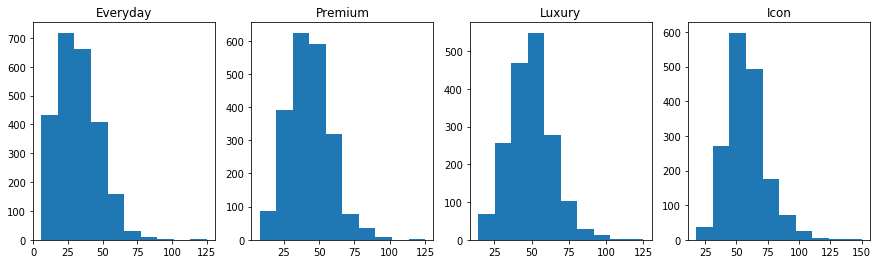

In [46]:
plt.figure(figsize=(15,4))

# BAR PLOT
plt.subplot(1, 4, 1)
plt.hist(df_pn20_pnt[df_pn20_pnt['point_rank']==0]['price'])
plt.title("{}".format('Everyday')) 

# DENSITY PLOT - HISTOGRAM
plt.subplot(1, 4, 2)
plt.hist(df_pn20_pnt[df_pn20_pnt['point_rank']==1]['price'])
plt.title("{}".format('Premium'))   
    
# TUKEY: DETECT OUTLIERS IN VARIABLES USING BOX PLOTS
plt.subplot(1, 4, 3)
plt.hist(df_pn20_pnt[df_pn20_pnt['point_rank']==2]['price'] )
plt.title("{}".format('Luxury')) 

# TUKEY: DETECT OUTLIERS IN VARIABLES USING BOX PLOTS
plt.subplot(1, 4, 4)
plt.hist(df_pn20_pnt[df_pn20_pnt['point_rank']==3]['price'] )
plt.title("{}".format('Icon'))

#### Bivariate: Description Length WRT Points and Ratings

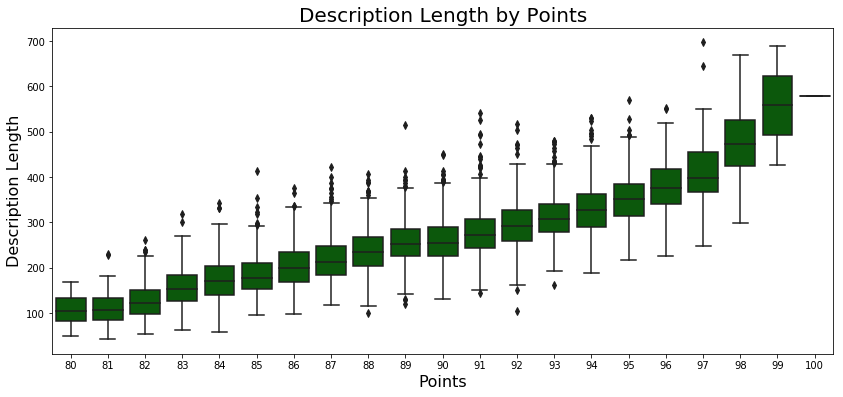

In [47]:
df_pn20_prc = df_pn20_prc.assign(desc_length = df_pn20_prc['description'].apply(len))
df_pn20_pnt = df_pn20_pnt.assign(desc_length = df_pn20_pnt['description'].apply(len))

plt.figure(figsize=(14,6))
g = sns.boxplot(x='points', y='desc_length', data=df_pn20_prc,
                color='darkgreen')
g.set_title('Description Length by Points', fontsize=20)
g.set_ylabel('Description Length', fontsize = 16) # Y label
g.set_xlabel('Points', fontsize = 16) # X label
plt.show()

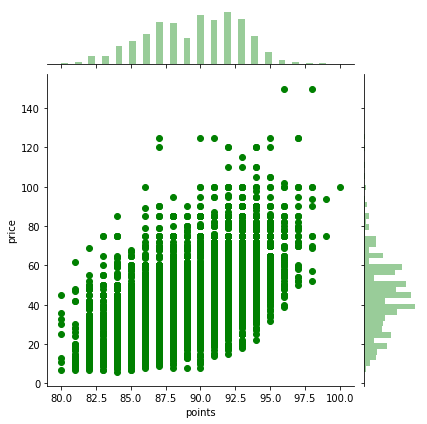

In [48]:
sns.jointplot(x=df_pn20_pnt['points'], y=df_pn20_prc['price'], color='g');

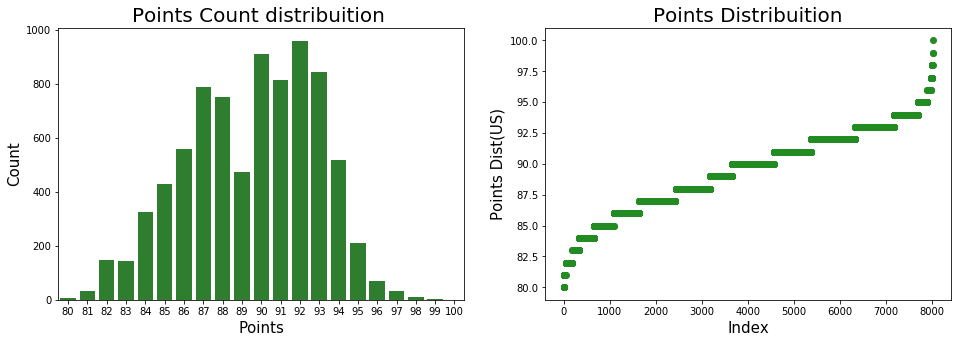

In [49]:
# define the size of figures that I will build
plt.figure(figsize=(16,5))

plt.subplot(1,2,1) # this will create a grid of 1 row and 2 columns; this is the first graphic
g = sns.countplot(x='points', data=df_pn20_pnt, color='forestgreen') # seting the seaborn countplot to known the points distribuition
g.set_title("Points Count distribuition ", fontsize=20) # seting title and size of font
g.set_xlabel("Points", fontsize=15) # seting xlabel and size of font
g.set_ylabel("Count", fontsize=15) # seting ylabel and size of font

plt.subplot(1,2,2)  # this will set the second graphic of our grid
plt.scatter(range(df_pn20_pnt.shape[0]), np.sort(df_pn20_pnt.points.values), color='forestgreen') # creating a cumulative distribution
plt.xlabel('Index', fontsize=15)  # seting xlabel and size of font
plt.ylabel('Points Dist(US)', fontsize=15)  # seting ylabel and size of font
plt.title("Points Distribuition", fontsize=20) # seting title and size of font

plt.show() #rendering the graphs

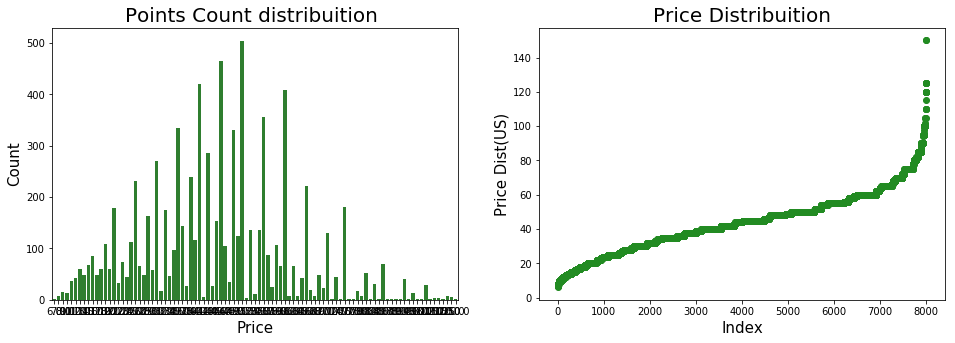

In [50]:
# define the size of figures that I will build
plt.figure(figsize=(16,5))

plt.subplot(1,2,1) # this will create a grid of 1 row and 2 columns; this is the first graphic
g = sns.countplot(x='price', data=df_pn20_prc, color='forestgreen') # seting the seaborn countplot to known the points distribuition
g.set_title("Points Count distribuition ", fontsize=20) # seting title and size of font
g.set_xlabel("Price", fontsize=15) # seting xlabel and size of font
g.set_ylabel("Count", fontsize=15) # seting ylabel and size of font
#plt.xticks(rotation=90);

plt.subplot(1,2,2)  # this will set the second graphic of our grid
plt.scatter(range(df_pn20_prc.shape[0]), np.sort(df_pn20_prc.price.values), color='forestgreen') # creating a cumulative distribution
plt.xlabel('Index', fontsize=15)  # seting xlabel and size of font
plt.ylabel('Price Dist(US)', fontsize=15)  # seting ylabel and size of font
plt.title("Price Distribuition", fontsize=20) # seting title and size of font
plt.show() #rendering the graphs

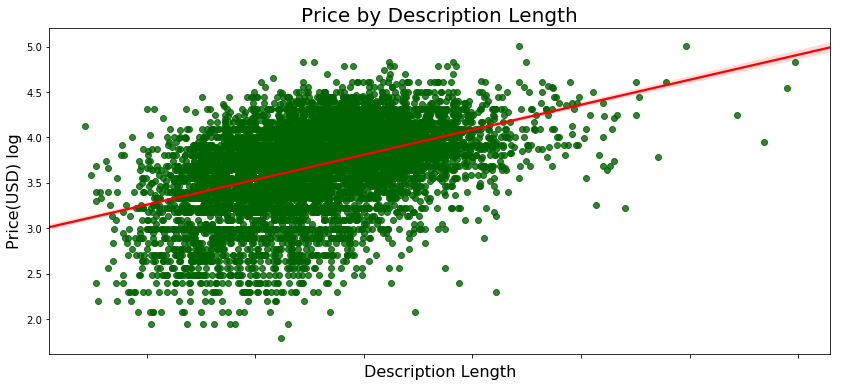

In [51]:
plt.figure(figsize=(14,6))

g = sns.regplot(x='desc_length', y='price_log', line_kws={'color':'red'},
                data=df_pn20_prc, fit_reg=True, color='darkgreen', )
g.set_title('Price by Description Length', fontsize=20)
g.set_ylabel('Price(USD) log' , fontsize = 16) 
g.set_xlabel('Description Length', fontsize = 16)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

plt.show()

[Text(0.5, 0, 'points')]

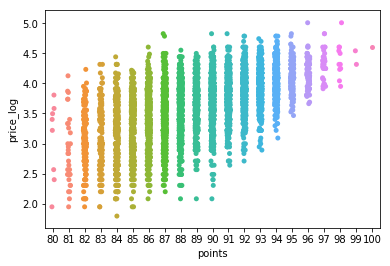

In [52]:
pnt_prc = sns.stripplot(x='points', y='price_log', data=df_pn20_prc, jitter=True)  
pnt_prc.set(xlabel='points')  

In [53]:
print(df_pn20_prc.columns)

Index(['description', 'designation', 'points', 'price', 'province', 'region_1',
       'winery', 'title', 'price_log', 'price_rank', 'reg1_prc_mean',
       'reg1_prc_rank', 'prc_2_reg1prc_ratio', 'desc_length'],
      dtype='object')


#### STANDARDIZE PRICE DATA 

#### !!! ZACK NOTES REVIEW, PRICE_RANK (0-3), DESCRIPTION RANK(COULD BE 100s) STANDARDIZE THESE AS WELL

In [54]:
from sklearn.preprocessing import StandardScaler, PowerTransformer # Yeo-Johnson or Boxcox

# TRANSFORMATION: Yeo-Johnson DUE TO NEGATIVE AND ZERO NUMERIC VALUES IN CONTINUOUS VARIABLES
pt = PowerTransformer(standardize=True, copy=False) # Yeo-Johnson is default
df_trans = pt.fit_transform(df_pn20_prc[['price', 'price_rank', 'reg1_prc_mean','reg1_prc_rank', 
                                         'prc_2_reg1prc_ratio', 'desc_length']])

In [55]:
df_trans = pd.DataFrame(df_trans, columns=['price_yj', 'price_rank_yj', 'reg1_prc_mean_yj',
                                           'reg1_prc_rank_yj', 'prc_2_reg1prc_ratio_yj', 
                                           'desc_length_yj'])

In [56]:
df_trans.shape

(8013, 6)

In [57]:
df_trans.columns

Index(['price_yj', 'price_rank_yj', 'reg1_prc_mean_yj', 'reg1_prc_rank_yj',
       'prc_2_reg1prc_ratio_yj', 'desc_length_yj'],
      dtype='object')

In [58]:
df_pn20_prc.shape

(8013, 14)

In [59]:
print(break_so_can_look_at)

NameError: name 'break_so_can_look_at' is not defined

#### !!! WHY NOT MERGING? CONCATENATE FAILS

In [67]:
#df_pn20_prc = pd.concat([df_pn20_prc, df_trans], axis=1)
pd.merge(df_pn20_prc, df_trans, left_index=True, right_index=True);
#df_pn20_prc.join(df_trans);
df_pn20_prc.head()

,description,designation,points,price,province,region_1,winery,title,price_log,price_rank,reg1_prc_mean,reg1_prc_rank,prc_2_reg1prc_ratio,desc_length
9,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Blue Farm,NaN,4.094345,3,50.219882,2.0,1.194746,307
19,This fresh and lively medium-bodied wine is be...,Gap's Crown Vineyard,95,75.0,California,Sonoma Coast,Gary Farrell,NaN,4.317488,3,50.219882,2.0,1.493432,260
24,"San Jose-based producer Adam Comartin heads 1,...",R-Bar-R Ranch,95,45.0,California,Santa Cruz Mountains,Comartin,NaN,3.806662,2,45.466926,8.0,0.989730,341
28,"Cranberry, baked rhubarb, anise and crushed sl...",Garys' Vineyard,94,60.0,California,Santa Lucia Highlands,Roar,NaN,4.094345,3,47.203498,7.0,1.271092,292
71,This wine draws from a handful of tremendous v...,NaN,91,45.0,California,Sonoma Coast,Red Car,NaN,3.806662,2,50.219882,2.0,0.896059,240


In [61]:
df_pn20_prc.shape

(8013, 14)

In [ ]:
df_pn20_prc.head()

In [ ]:
print(break_so_can_look_at)

In [62]:
'''
# DROPPING ORIGINAL PRE-TRANSFORMATION VARIABLES
df_pn20_prc.drop("price", axis=1, inplace=True)  
df_pn20_prc.drop("price_rank", axis=1, inplace=True) 
df_pn20_prc.drop("reg1_prc_mean", axis=1, inplace=True)
df_pn20_prc.drop("reg1_prc_rank", axis=1, inplace=True)
df_pn20_prc.drop("prc_2_reg1prc_ratio", axis=1, inplace=True)
df_pn20_prc.drop("desc_length", axis=1, inplace=True)
df_pn20_prc.drop("points", axis=1, inplace=True)
'''

'\n# DROPPING ORIGINAL PRE-TRANSFORMATION VARIABLES\ndf_pn20_prc.drop("price", axis=1, inplace=True) \ndf_pn20_prc.drop("price_rank", axis=1, inplace=True) \ndf_pn20_prc.drop("reg1_prc_mean", axis=1, inplace=True)\ndf_pn20_prc.drop("reg1_prc_rank", axis=1, inplace=True)\ndf_pn20_prc.drop("prc_2_reg1prc_ratio", axis=1, inplace=True)\ndf_pn20_prc.drop("desc_length", axis=1, inplace=True)\ndf_pn20_prc.drop("points", axis=1, inplace=True)\n'

#### ONE HOT ENCODING

In [ ]:
one_hot_list_all = []
cat_list = ['region_1']

for feature in cat_list:
    df_pn20_prc = pd.concat([df_pn20_prc, pd.get_dummies(df_pn20_prc[feature], prefix=feature, 
                                                         drop_first=True)], axis=1)
    one_hot_list_all.extend(list(pd.get_dummies(df_pn20_prc[feature], prefix=feature, 
                                                drop_first=True).columns))
    df_pn20_prc.drop(feature, axis=1, inplace=True) 

In [ ]:
df_pn20_prc.columns

# NLP 

In [ ]:
print(len(STOPWORDS))
stopwords = set(STOPWORDS)
newStopWords = ['fruit', "drink", "black", 'wine', "pinot", "noir", "palate", "flavor", "note",
                'russian', 'river', 'valley', 'sonoma', 'coast', 'sta', 'santa', 'rita', 'hills',
                'lucia', 'highlands', 'carneros', 'anderson', 'maria','california', 'santa', 
                'cruz', 'mountains','edna', 'barbara', 'central', 'coast', 'sonoma','county', 
                'arroyo', 'grande Valley', 'monterey', 'san', 'luis', 'obispo', 'monterey', 
                'napa', 'arroyo', 'seco']
stopwords.update(newStopWords)
print(len(stopwords))

In [ ]:
# FUNCTIONS TO PREPROCESSING 
def lemmatize_stemming(text):
    # REDUCE WORD TO ROOT FORM
    # THIRD TO FIRST PERSON
    # VERB TENSES TO PRESENT
    # PUNCTUATION REMOVED
    # WORDS LOWER CASE
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# TOKENIZE AND LEMMANTIZE
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        # WORDS WITH FEWER 3 CHARACTERS ARE IGNORED
        # STOP WORDS ARE IGNORED, NOTE MODIFIED THE "stopwords"
        #if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
        if token not in stopwords and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return " ".join(result)
    #return result

df_pn20['clean_desc'] = df_pn20['description'].map(lambda x: preprocess(x)) 

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess2(sentence):
    # MAKE STRING
    sentence=str(sentence)
    # MAKE LOWER CASE
    sentence = sentence.lower()
    #REMOVE SOMETHING REPLACE WITH NOTHING
    #sentence=sentence.replace('something',"") 
    # REMOVE SPECIAL CHARACTERS AND PUCTUATION
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    # REMOVE NUMBERS
    rem_num = re.sub('[0-9]+', '', cleantext)
    # TOKENIZE
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    # IF LENGTH > 2 AND NOT A STOPWORD, PUT INTO LIST SEPERATED BY COMMAS
    filtered_words = [w for w in tokens if len(w) > 3 if not w in stopwords.words('english')]
    # GET STEM - CHOP WORD DOWN TO ROOT
    stem_words=[stemmer.stem(w) for w in filtered_words]
    # GET FUTURE AND PAST -> PRESENT
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    # RETURN A SPACE SEPERATED LIST
    return " ".join(filtered_words)

#df_pn20['clean_desc'] = df_pn20['description'].map(lambda x: preprocess2(x)) 

In [ ]:
# SET OPTION TO SEE ENTIRE SENTENCE
pd.set_option('display.max_colwidth', -1)
print(df_pn20['description'].head(1))
print()
print(df_pn20['clean_desc'].head(1))

In [ ]:
plt.figure(figsize= (16,8))
plt.title('Word cloud of Description')
wc = WordCloud(max_words=1000,max_font_size=40,
               background_color='black', 
               #stopwords = stopwords, 
               stopwords = STOPWORDS, 
               colormap='Set1')
wc.generate(' '.join(df_pn20['clean_desc']))
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')

In [ ]:
# https://github.com/DougJ/Public/blob/master/Final%20Capstone%201.0.ipynb

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(
    #max_df=0.1,  # THIS DOESN'T APPEAR TO BE HAVING ANY IMPACT HIGH OR LOW
    min_df=0.01, 
    analyzer='word', 
    token_pattern=r'\w{1,}', 
    ngram_range=(1,3), 
    max_features=5000,
    stop_words='english', 
    #stop_words=stopwords, 
    lowercase=False,
    vocabulary=None)

# FIT ON ENTIRE
tfidf_ngram = tfidf_vect_ngram.fit_transform(df_pn20['clean_desc'])
tfidf_ngram_feat = tfidf_vect_ngram.get_feature_names()
#type(tfidf_ngram)
#print(type(tfidf_ngram_feat))
#print(tfidf_ngram_feat)

In [ ]:
#tfidf_feature_names = vectorizer.get_feature_names()
#print(type(tfidf_feature_names))
#print(tfidf_feature_names)

In [ ]:
#print(tfidf_wine.shape)
print(df_pn20.shape)
print(tfidf_ngram.shape)
#print(tfidf_ngram_feat)

In [ ]:
# ??? RESEARCH: ALLEGEDLY THIS DOES IT - WHY MORE STEPS IN MY APPROACH?
# pd.DataFrame(A.todense())

# USE THIS TO GET INTO DATAFRAME VS CSR MATRIX
# GO FROM SPARSE TO DENSE, PUT INTO LIST, CONVERT LIST TO DATAFRAME
dense = tfidf_ngram.todense()
denselist = dense.tolist()
df_tfidf_ngram_wine = pd.DataFrame(denselist, columns=tfidf_ngram_feat)
#print(type(df_tfidf_ngram_wine))
#df_tfidf_ngram_wine['rev_w_cnt'] = 1
df_tfidf_ngram_wine.head()

In [ ]:
#df_tfidf_ngram_wine.isnull().mean()

In [ ]:
# !!! THIS IS WORKING NOW, CONCAT DOESN'T WORK
# Merge two dataframes by index
# https://stackoverflow.com/questions/40468069/merge-two-dataframes-by-index#40468090
pd.merge(df_pn20, df_tfidf_ngram_wine, left_index=True, right_index=True)

#Or join, which is left join by default:
#df_pn20.join(df_tfidf_ngram_wine)

#Or concat, which is outer join by default:
#pd.concat([df_pn20, df_tfidf_ngram_wine], axis=1)

#### PCA

In [ ]:
from sklearn.decomposition import PCA
# SET PCA ABOVE 80% VARIANCE EXPLAINED, HOWEVER MANY COMPONENTS
selector = PCA(n_components=.8).fit(X,y)
# SELECT # COMPONENTS
#selector = PCA(n_components=10).fit(X,y)

var_explained = selector.explained_variance_ratio_ 
var_explained = pd.Series(var_explained)
print(round(var_explained,4)) 

In [ ]:
pca = PCA(n_components = 10)
logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
pipeline = Pipeline([('pca', pca), ('logistic', logreg)])
score_fs_pca = cross_val_score(pipeline, X, y, scoring="f1_weighted", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs_pca.mean(),
                                                        score_fs_pca.std()*2, score_fs_pca))

#### UMAP

In [ ]:
### Step X: Clustering - Do after NLP !!! Do after PCA? what if umap
### Remove collinearity. Stanardize

# DO UMAP ONCE HAVE FEATURES AND AFTER DO PCA

import umap

# DO LOCATION AND PRICE, LOCATION AND RATING
# DO NORMALIZED, OR THE LOG 
X = df_pn20.loc[:,['price','points']].values

umap_results = umap.UMAP(n_neighbors=30, min_dist=1,
                         metric='correlation').fit_transform(X)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## TOPIC MODELING DO IN EDA, GET GREATER INSIGHT INTO TOPICS, PERHAPS AFTER CLUSTERING, SO CAN USE THAT AS NUMBER OF TOPICS

In [ ]:
# Number of topics.
ntopics=20

# Number of words to look at for each topic.
n_top_words = 10

# Linking words to topics
def word_topic(tfidf, solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

In [ ]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
wine_lsa = lsa.fit_transform(tfidf_wine)

lsa_components = word_topic(tfidf_wine, wine_lsa, tfidf_feature_names)

topwords=pd.DataFrame()
topwords['LSA']=top_words(lsa_components, n_top_words)                

In [ ]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

lda_wine = lda.fit_transform(tfidf_wine) 

lda_components = word_topic(tfidf_wine, lda_wine, tfidf_feature_names)

topwords['LDA']=top_words(lda_components, n_top_words)


In [ ]:

# ??? WHAT EXACTLY IS todense() READ UP
#sentences_tfidf=vectorizer.fit_transform(sentences_alt)
#feature_names = vectorizer.get_feature_names()
#dense = sentences_tfidf.todense()
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df.head()

In [ ]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
nmf_wine = nmf.fit_transform(tfidf_wine) 

nmf_components = word_topic(tfidf_wine, nmf_wine, tfidf_feature_names)

topwords['NNMF']=top_words(nmf_components, n_top_words)

In [ ]:
#dense = tfidf_wine.todense()
#denselist = dense.tolist()
#df_tfidf_wine = pd.DataFrame(denselist, columns=tfidf_feature_names)
#df_tfidf_wine.head()

#sparse matrix, not really a matrix, efficient way to refer to matrix, can't apply math
# math that would be used when using other matrices

### STEP X:  RUN MODELS WITH GRIDSEARCHCV

### Step X: KNN - Suggest varietals to user based on nearest neighbor

In [ ]:
from sklearn.neighbors import NearestNeighbors # KNN Clustering 
from scipy.sparse import csr_matrix # Compressed Sparse Row matrix
from sklearn.decomposition import TruncatedSVD # Dimensional Reduction

In [ ]:
# Lets choice rating of wine is points, title as user_id, and variety,
col = ['province','variety','points']

wine1 = df[col]
wine1 = wine1.dropna(axis=0)
wine1 = wine1.drop_duplicates(['province','variety'])
wine1 = wine1[wine1['points'] > 85]

wine_pivot = wine1.pivot(index= 'variety',columns='province',values='points').fillna(0)
wine_pivot_matrix = csr_matrix(wine_pivot)

In [ ]:
knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(wine_pivot_matrix)

In [ ]:
for n in range(5):
    query_index = np.random.choice(wine_pivot.shape[0])
    #print(n, query_index)
    distance, indice = model_knn.kneighbors(wine_pivot.iloc[query_index,:].values.reshape(1,-1), n_neighbors=6)
    for i in range(0, len(distance.flatten())):
        if  i == 0:
            print('Recommendation for ## {0} ##:'.format(wine_pivot.index[query_index]))
        else:
            print('{0}: {1} with distance: {2}'.format(i,wine_pivot.index[indice.flatten()[i]],distance.flatten()[i]))
    print('\n')

### Step X: KNN - Suggest varietals to user based on nearest neighbor

In [ ]:
# DUPLICATES APPEAR TO BE IN DATAFRAME ROWS, LIKELY ALL ZEROS
df_tfidf_ngram_wine[df_tfidf_ngram_wine.duplicated(keep=False)==True].head(2)

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

In [ ]:
wine1 = df.copy()

In [ ]:
# !!! TRY TO ADD A UNIQUE ITEM TO REMOVE DUPLICATE

#df_tfidf_ngram_wine.duplicated()

# VIEW DUPLICATES
#df_tfidf_ngram_wine[df_tfidf_ngram_wine.duplicated(keep=False)==True].head(2)

# THERE ARE DUPLICATES
#df_tfidf_ngram_wine["rev_w_cnt"] = len(df_pn20['desc_length'])

#def description_length(row):
#    return 2 #len(row['cleanDesc'])

#df_tfidf_ngram_wine['rev_w_cnt'] = ''
#df_tfidf_ngram_wine.reset_index();
#df_pn20.reset_index();
#df_tfidf_ngram_wine['rev_w_cnt'] = df_pn20.apply(description_length, axis=1)
#df_tfidf_ngram_wine['rev_w_cnt'] = df_pn20['cleanDesc'].apply(lambda x: description_length(x)) 
#df_tfidf_ngram_wine['rev_w_cnt'] = df_pn20['cleanDesc'].map(lambda x: description_length(x))
#df_tfidf_ngram_wine.assign(desc_length = df_pn20['description'].apply(len))

#df_tfidf_ngram_wine['rev_w_cnt'].head()

In [ ]:
# Lets choice rating of wine is points, title as user_id, and variety,
col = ['province','variety','points']
wine1 = df[col]
wine1 = wine1.dropna(axis=0)
wine1 = wine1.drop_duplicates(['province','variety'])
wine1 = wine1[wine1['points'] >85]
wine_pivot = wine1.pivot(index= 'variety',columns='province',values='points').fillna(0)
wine_pivot_matrix = csr_matrix(wine_pivot)

In [ ]:
df_tfidf_ngram_wine.head()

In [ ]:
knn = NearestNeighbors(n_neighbors=10,algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(wine_pivot_matrix)

In [ ]:
query_index = np.random.choice(wine_pivot.shape[0])
distance, indice = model_knn.kneighbors(wine_pivot.iloc[query_index,:].values.reshape(1,-1),n_neighbors=6)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendation for {0}:\n'.format(wine_pivot.index[query_index]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,wine_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

In [ ]:
df_pn20_tdidf = pd.concat([df_pn20, df_tdidf], axis=1, sort=False)

In [ ]:
# DETERMINE OPTIMAL CLUSTER NUMBER 
# ELBOW METHOD -> WITHIN CLUSTER SUM OF SQUARES (WCSS)
wcss = []
for i in range(1,8):
    kmeans = KMeans(n_clusters = i, init = 'random', max_iter = 300,
                    n_init = 10, random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,8), wcss)
plt.title('Elbow Method')
plt.xlabel('# Clusters')
plt.ylabel('WCSS')
plt.show()